In [201]:
#from the py_geospatial environment
import glob
import os
import baseflow #this is the baseflow package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#use segoe font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Segoe UI'

In [179]:
#flow data
src = "W:/VUB/_main_research/mHM/model_validation_data/waterinfo_csv/waterinfo_timeseries"

#### Baseflow filter with different methods

In [ ]:
datafiles = glob.glob(src + "/*.csv")
#extract the station name
station_names = [os.path.basename(file).split('_')[0] for file in datafiles]

#dictionary to store the results
baseflow_dict= {}
bfi_dict = {}

for name, file in zip(station_names, datafiles):
    df = pd.read_csv(file, dayfirst=True, index_col=0, parse_dates=True)
    station_name = os.path.basename(file).split('_')[0]
    print(f'Processing {station_name}')
    dfs, bfi = baseflow.separation(df, method='EWMA', return_bfi=True)

    #get the df from the dictionary
    df_q = dfs['EWMA']

    #get the bfi
    bfi_dict[station_name] = bfi

    df_stat = pd.concat([df, df_q], axis=1)
    df_stat.columns = ['Q', 'Q_bf']

    baseflow_dict[station_name] = df_stat
    
    #print(f'Best Method:\n{df_kge.idxmax(axis=1)}')

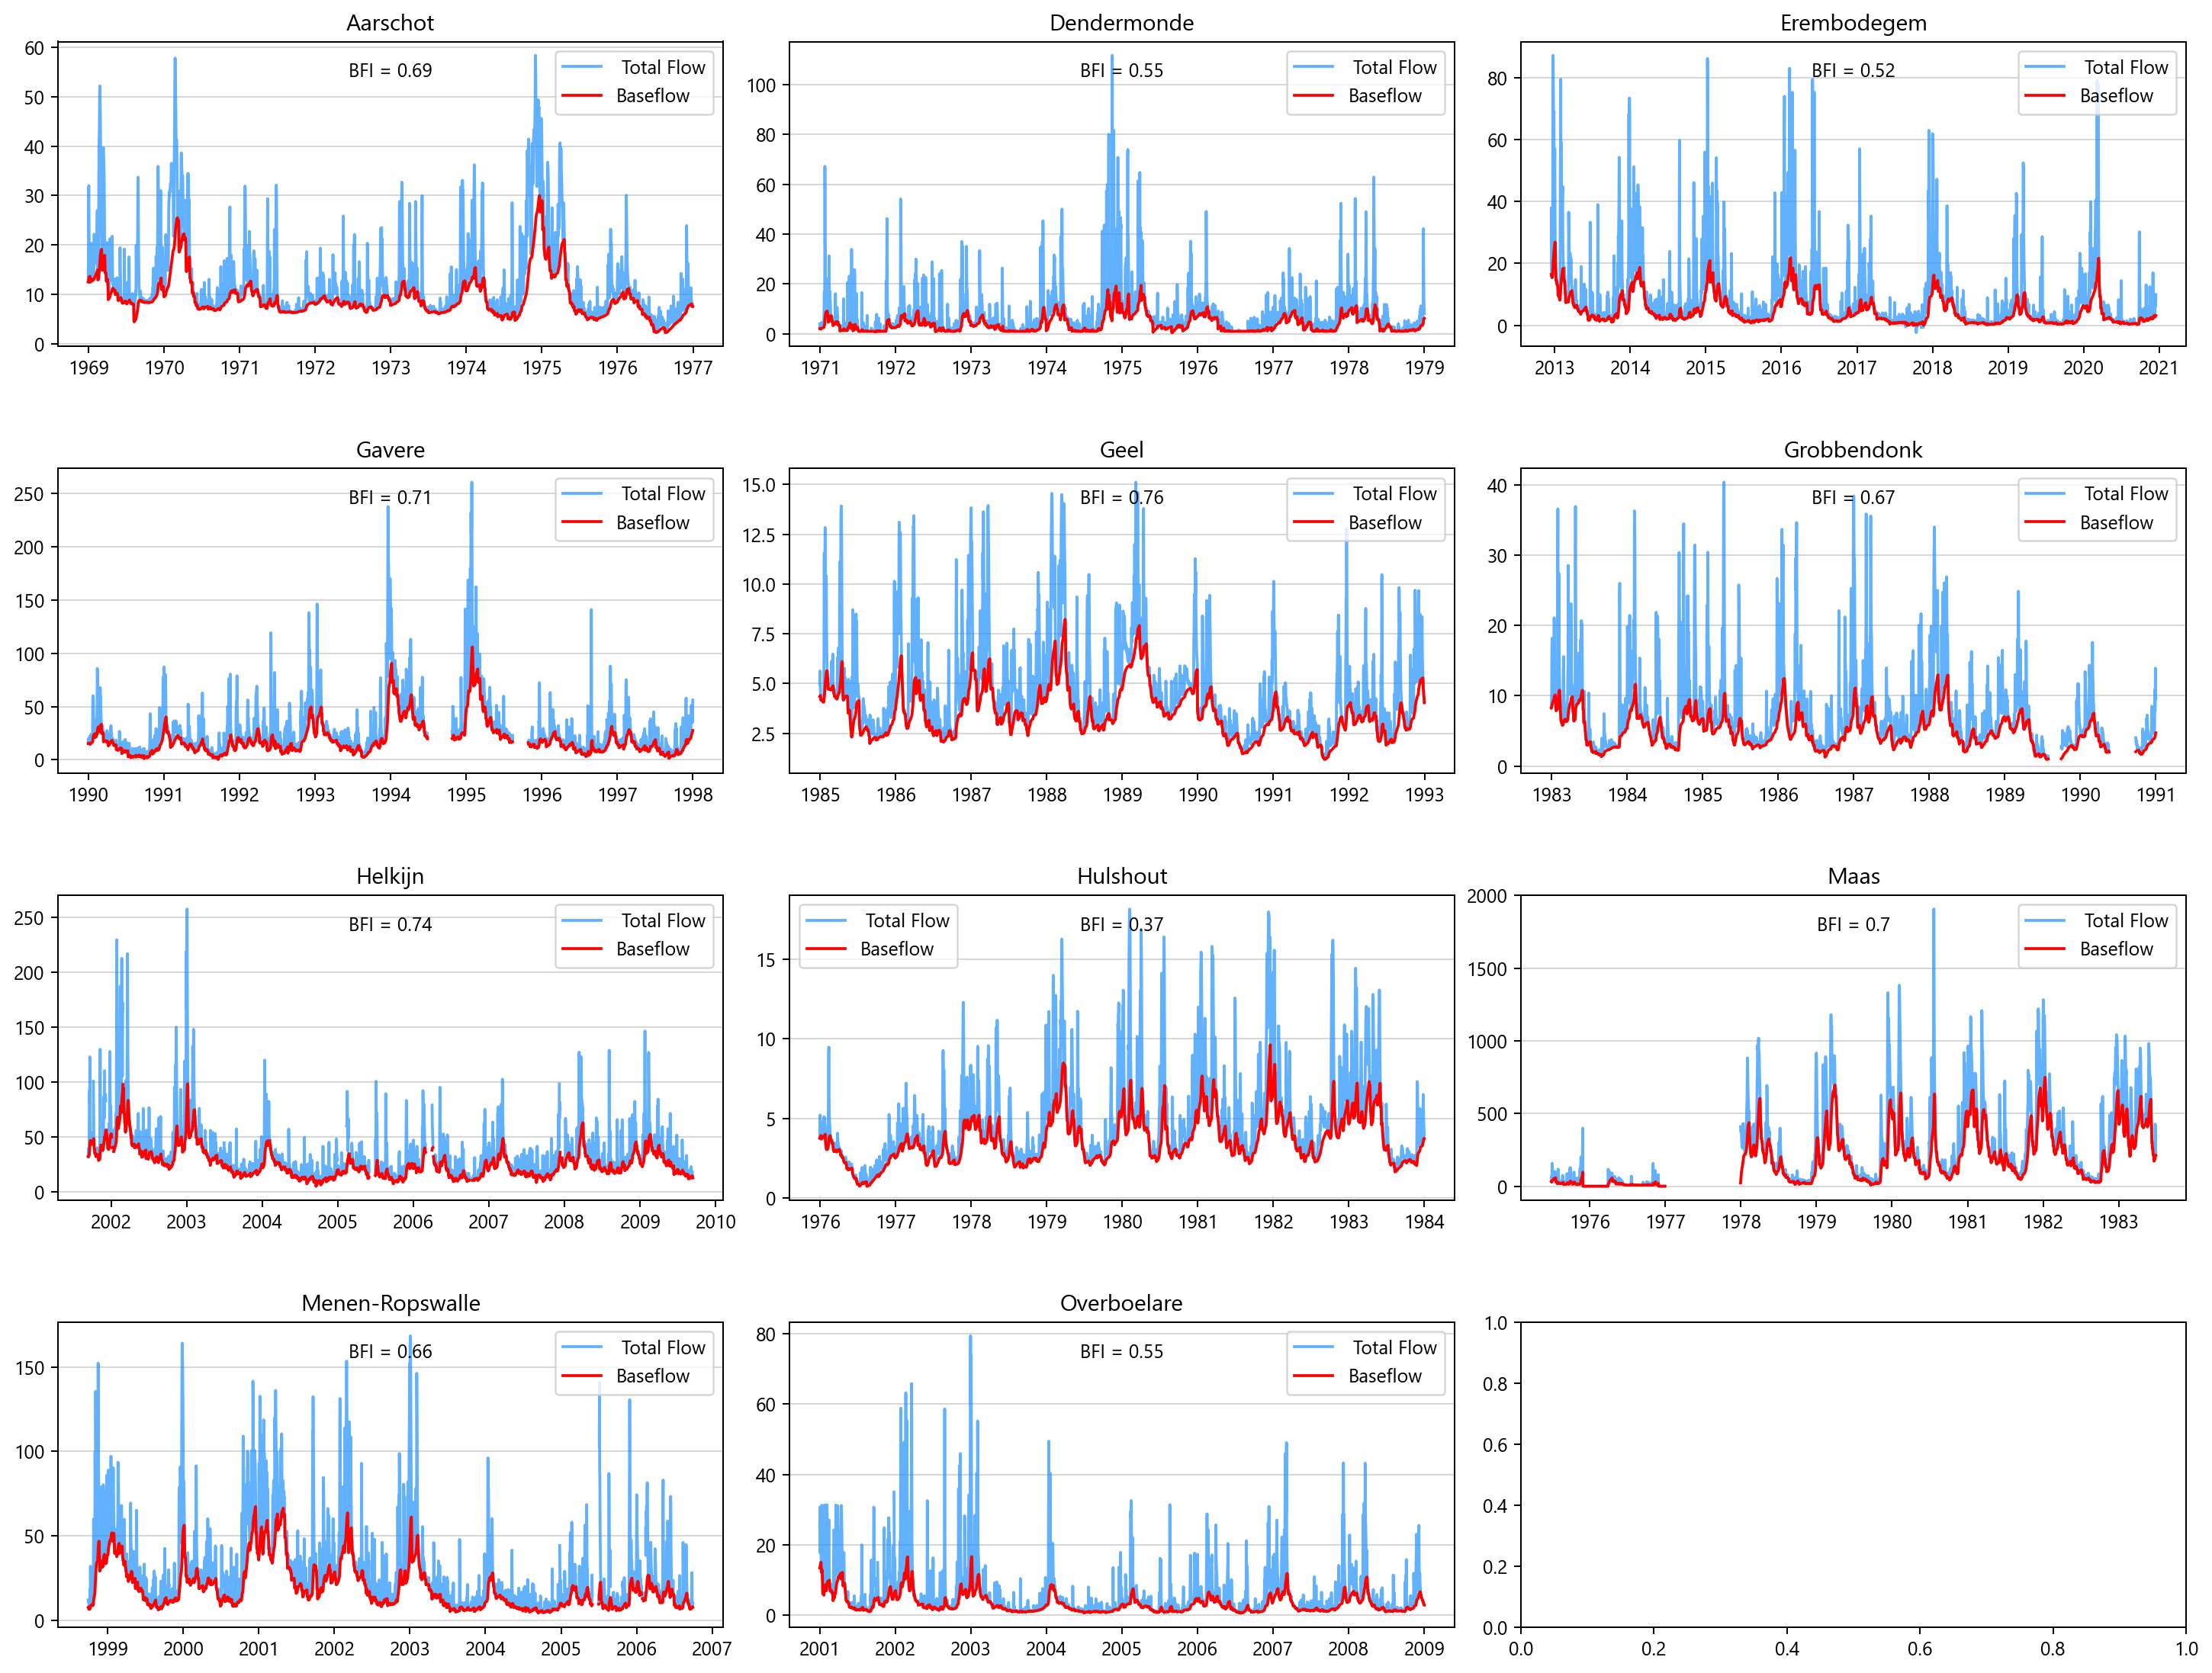

In [280]:
nrows = 4
ncols = 3

fig,axes = plt.subplots(nrows, ncols, figsize=(20,15), dpi=180)
ax = axes.flatten()

#spaces between the subplots
plt.subplots_adjust(wspace=0.1, hspace=0.4)

for ax, name in zip(ax, baseflow_dict.keys()):

    df = baseflow_dict[name]
    bfi = bfi_dict[name].values[0][0]
    
    bfi = round(bfi, 2)

    #plot the hydrograph
    min_date = df.index.min()
    max_date = min_date + pd.DateOffset(years=8)

    ax.plot(df['Q'][min_date:max_date], label=' Total Flow', color='dodgerblue', alpha=0.7)   
    ax.plot(df['Q_bf'][min_date:max_date], label='Baseflow', color='r')
    ax.set_title(name)
    ax.text(0.5, 0.9, f'BFI = {bfi}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.grid(axis='y', alpha=0.5)
    ax.legend()

    #remove empty subplots
    # Remove any unused subplots


    #plot the baseflow
    # plt.plot(dfs['Willems'][min_date:max_date], label='Willems')
    # plt.plot(dfs['Eckhardt'][min_date:max_date], label='Eckhardt')
    # plt.plot(dfs['Furey'][min_date:max_date], label='Furey')
    # plt.plot(dfs['Boughton'][min_date:max_date], label='Boughton')